# Readouts

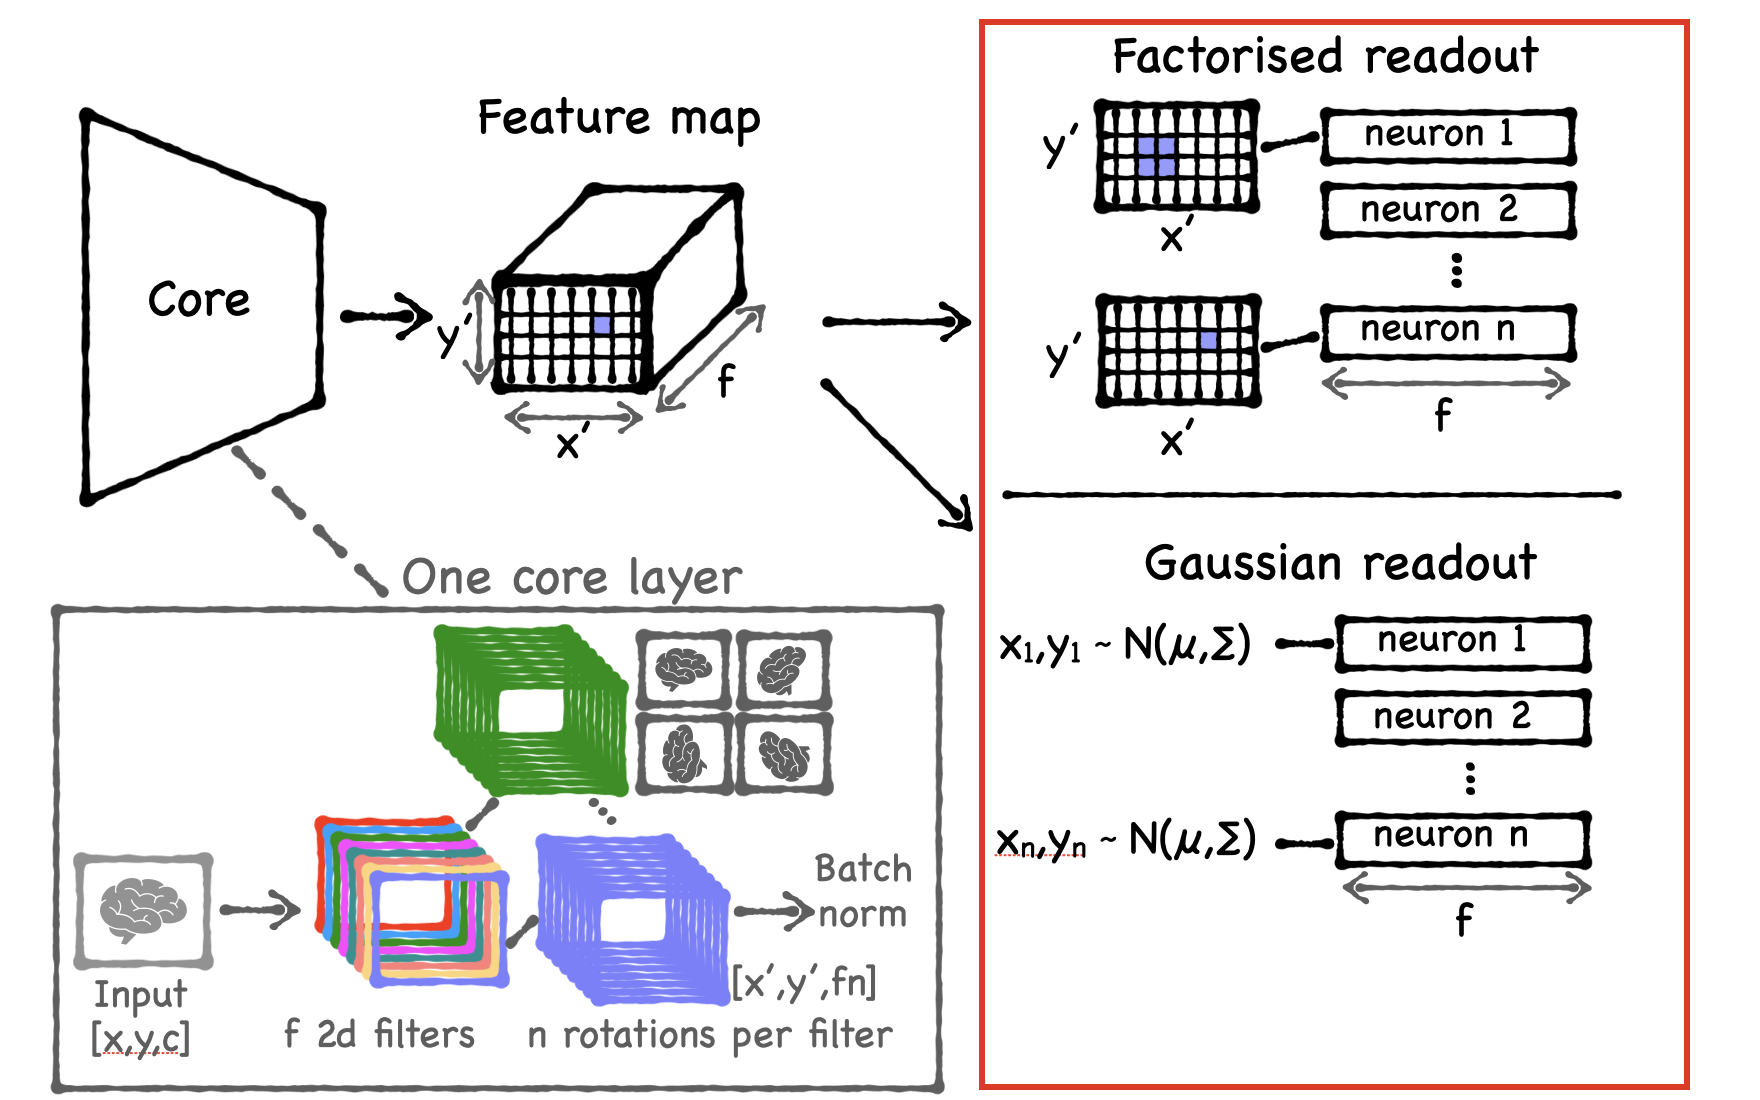

All the models in this library are constructed around two main components:
- **core**: the core aims to (nonlinearly) extract features that are common between neurons. That is, we assume there exist a shared set of features that all neurons use but combine them in their own unique way.
- **readout**: once the core extracts the features, then we can predict neural activity by simply linearly combining those features into a single value.

By keeping the readout component of the network simple, during training we force most of the computations to be captured by the shared core.

While the core is shared among recording sessions, allowing to use more data for the shared representation learning, the  readout network (or networks), are different for each recording session, as each session will contain a different set of unique neurons we want to predict. 



In [1]:
import warnings
import random
import torch
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)
device = "cuda" if torch.cuda.is_available() else "cpu"
random_seed = 42

# Readout essentials

All readout networks in the package are initialised with two basic arguments, needed to properly initialised the readout learnable parameters:

- `in_shape`
- `outdims`
- `bias`

On top of this, if your dataset contains multiple sessions, you will need to use some instantiation of the `MultiReadoutBase` class, which creates multiple readouts for each session. Paralleling each individual readout instantiation, the multiple readouts takes as arguments:
- `in_shape_dict`, which will feed into each single readout `in_shape`
- `n_neurons_dict`, which will feed into each single readout `outdims`

The keys of both these dictionaries will be the session names, which are also passed in the forward method of this class to choose which individual readout will take care of the forward pass.

For now, let us manually create these two dictionaries before instantiating our readouts, with information from the sample data we are going to import later.


In [2]:
in_shapes_dict = {
    '21067-10-18': torch.Size([64, 144, 256]),
    '22846-10-16': torch.Size([64, 144, 256])
}

n_neurons_dict = {'21067-10-18': 8372, '22846-10-16': 7344}

We are now going to examine the two most popular readouts in the library, the factorised and Gaussian readouts.

## Factorised readout

First introduced by [Klindt et al., 2017](https://papers.nips.cc/paper_files/paper/2017/hash/8c249675aea6c3cbd91661bbae767ff1-Abstract.html).

Here is a (technical) excerpt from the paper explaining how the factorised readout works:

"The [factorised] readout layer pools the output, $c$, of the convolutional layer by applying a sparse mask, $q$, for each neuron:
$$
\hat{r}_n = \sum_{i,j,k} c_{ijk} q_{ijkn}
$$
Here, $\hat{r}_n$ is the predicted firing rate of neuron $n$. The mask $q$ is factorized in the spatial and feature dimension:
$$
q_{ijkn} = m_{ijn} w_{kn},
$$
where $m$ is a spatial mask and $w$ is a set of $K$ feature weights for each neuron. The spatial mask and feature weights encode each neuron’s receptive field location and cell type, respectively. As we
expect them to be highly sparse, we regularize both by an L1 penalty (with strengths $\lambda_m$ and $\lambda_w$ ).

By factorizing the spatial and feature dimension in the readout layer, we achieve several useful properties: first, it reduces the number of parameters substantially compared to a fully-connected layer; second, it limits the expressiveness of the layer, forcing the ‘computations’ down to the convolutional layers, while the readout layer performs only the selection; third, this separation of computation from selection facilitates the interpretation of the learned parameters in terms of functional cell types. "

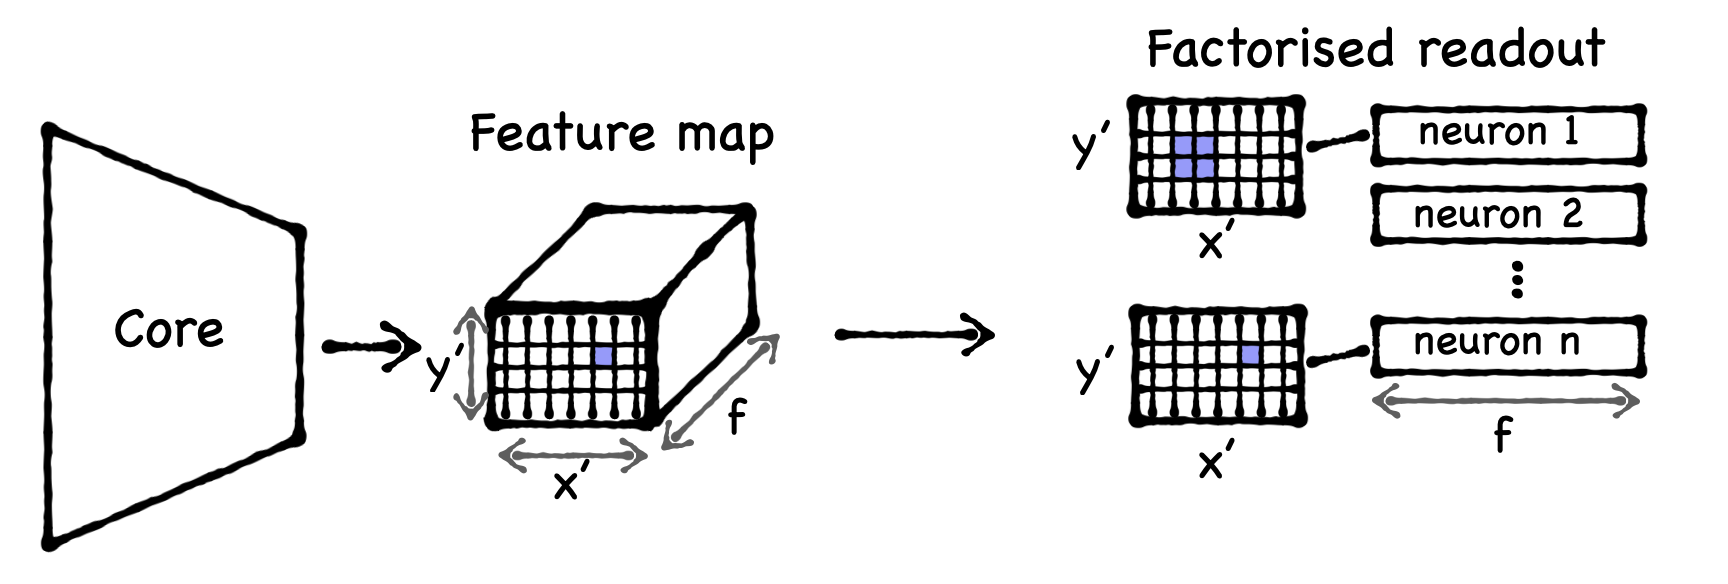

In [3]:
from neuralpredictors.layers.readouts.factorized import FullFactorized2d
from neuralpredictors.layers.readouts.multi_readout import MultiReadoutBase

In [4]:
factorized_readout = MultiReadoutBase(
    in_shape_dict=in_shapes_dict,
    n_neurons_dict=n_neurons_dict,
    base_readout=FullFactorized2d,
    bias=True,
)

In [5]:
# The multi-readout layer is an instatiation of torch.ModuleDict, 
# so we can access the individual readouts by their session key

factorized_readout["21067-10-18"]

FullFactorized2d (64 x 144 x 256 -> 8372) with bias, normalized

## Gaussian readout

First introduced by [Lurz et al., 2021](https://www.biorxiv.org/content/10.1101/2020.10.05.326256v2)

Here is a (technical) excerpt from the paper explaining how the Gaussian readout works:

"[the] Gaussian readout reduces the number of per-neuron parameters. It computes a linear combination of the feature activations at a single spatial position — parametrized as (x, y) coordinates — via bilinear interpolation. To facilitate gradient flow during training, we replace the spatial downsampling used in (Sinz et al., 2018) by a sampling step, which during training draws the readout position of each $n$ -th neuron from a bivariate Gaussian distribution $\mathcal{N}$($\mu_n$, $\Sigma_n$) for each image in a batch separately. This is the sampling version of (St-Yves & Naselaris, 2017) where the readout location is weighted spatially with a Gaussian profile. In our case, $\mu_n$ and $\Sigma_n$ are learned via the reparametrization trick (Kingma & Welling, 2014). Initializing $\Sigma_n$ large enough ensures that there is gradient information available to learn $\mu_n$ reliably. During training, $\Sigma_n$ shrinks as the estimate of the neuron position improves. During evaluation we always use the position defined by $\mu_n$, making the readout deterministic. This version of the Gaussian readout has $c + 7$ parameters per neuron (2 for $\mu$, 4 for $\Sigma$ because the linear mapping in the reparametrization trick is 2 × 2, and 1 for the scalar bias)."

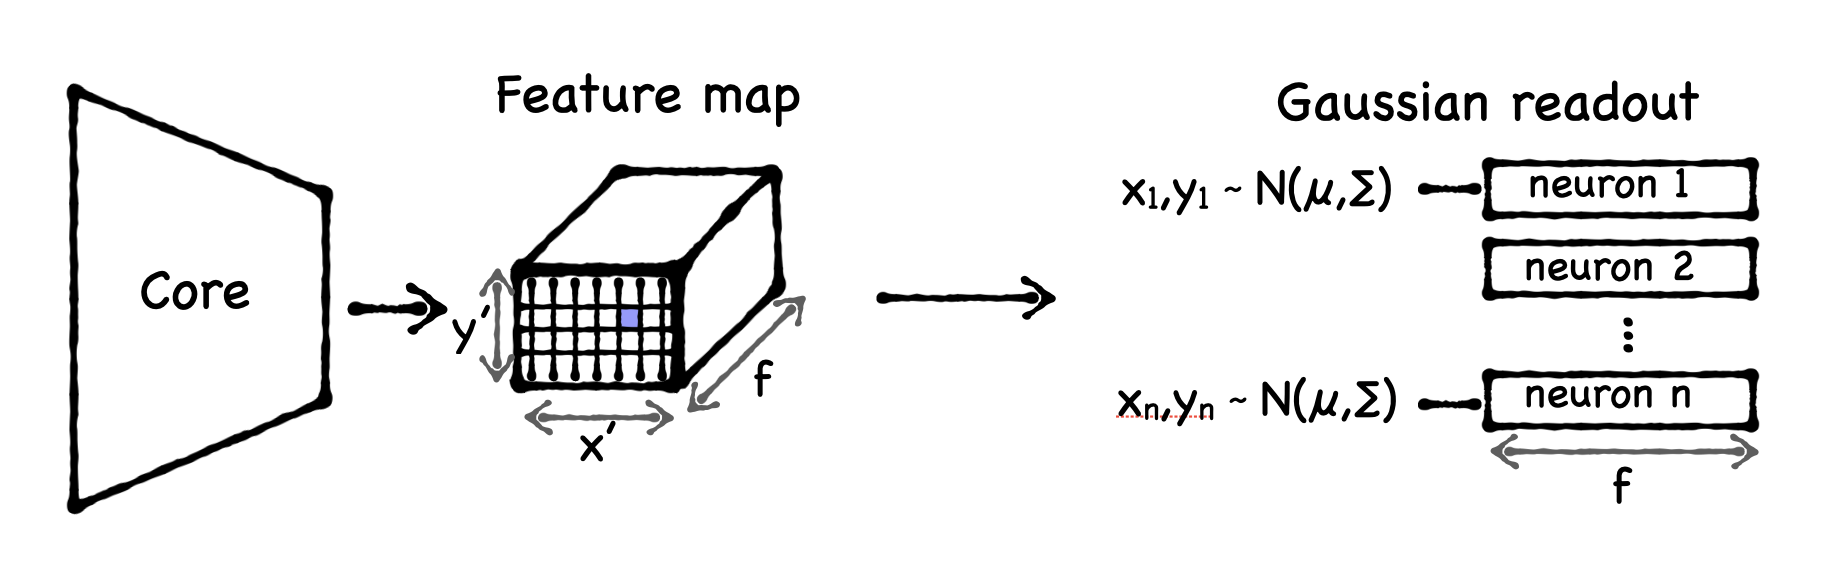

In [6]:
from neuralpredictors.layers.readouts.gaussian import Gaussian2d

In [7]:
gaussian_readout = MultiReadoutBase(
    in_shape_dict=in_shapes_dict,
    n_neurons_dict=n_neurons_dict,
    base_readout=Gaussian2d,
    bias=True,
)

In [8]:
# Again, the multi-readout layer is an instatiation of torch.ModuleDict, 
# so we can access the individual Gaussian readouts by their session key
gaussian_readout["21067-10-18"]

Gaussian2d (64 x 144 x 256 -> 8372) with bias

---

## Importing data and testing our readouts

Let us import some data and define a sample core from which we will readout.
You can download the data [here](https://gin.g-node.org/cajal/Sensorium2022/src/master/static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip) and [here](https://gin.g-node.org/cajal/Sensorium2022/src/master/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip).

We will also need some utility functions from `sensorium`, so you can run the next cell to install them if you have not done so already.

In [9]:
%%capture 
!pip install git+https://github.com/sinzlab/sensorium.git

We will also need some helper function to load the data, which we define in the next cell:

In [10]:
# The following are minimal adaptations of three utility functions found in nnfabrik that we need to initialise
# the core and readouts later on.

def get_data(dataset_fn, dataset_config):
    """
    See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/builder.py#L87
    for the original implementation and documentation if you are interested.
    """
    return dataset_fn(**dataset_config)

def get_dims_for_loader_dict(dataloaders):
    """
    See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L39
    for the original implementation and docstring if you are interested.
    """
    
    def get_io_dims(data_loader):
        items = next(iter(data_loader))
        if hasattr(items, "_asdict"):  # if it's a named tuple
            items = items._asdict()

        if hasattr(items, "items"):  # if dict like
            return {k: v.shape for k, v in items.items()}
        else:
            return (v.shape for v in items)

    return {k: get_io_dims(v) for k, v in dataloaders.items()}


def set_random_seed(seed: int, deterministic: bool = True):
    """
    See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L53
    for the original implementation and docstring if you are intereseted.
    """
    random.seed(seed)
    np.random.seed(seed)
    if deterministic:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)  # this sets both CPU and CUDA seeds for PyTorch


In [11]:
## Load the data: you can modify this if you have stored it in another location
from sensorium.datasets import static_loaders

filenames = [
    '../../data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip', 
    '../../data/static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip'
    ]

dataset_config = {'paths': filenames,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': True,
                 'batch_size': 32,
                 'scale':1,
                 'cuda': True if device == 'cuda' else False,
                 }

dataloaders = get_data(dataset_fn=static_loaders, dataset_config=dataset_config)

In [12]:
model_config = {
    # core args
    'input_kern': 9,
    'hidden_kern': 7,
    'hidden_channels': 64,
    'layers': 4,
    'depth_separable': True,
    'stack': -1,
    'gamma_input': 6.3831,
}

Let us define a sample core network to use in this example

In [13]:
from neuralpredictors.layers.cores import Stacked2dCore

# We only need the train dataloaders to extract the session keys (could also use test or validation for this)
train_dataloaders = dataloaders["train"]

# Obtain the named tuple fields from the first entry of the first dataloader in the dictionary
example_batch = next(iter(list(train_dataloaders.values())[0]))
in_name, out_name = (
    list(example_batch.keys())[:2] if isinstance(example_batch, dict) else example_batch._fields[:2]
)

session_shape_dict = get_dims_for_loader_dict(train_dataloaders)
input_channels = [v[in_name][1] for v in session_shape_dict.values()]

core_input_channels = (
    list(input_channels.values())[0]
    if isinstance(input_channels, dict)
    else input_channels[0]
)

set_random_seed(random_seed)

core = Stacked2dCore(
    input_channels=core_input_channels,
    **model_config,
)


Let us now do an example forward pass through the core to see how the readout works

In [14]:
print(f"Sample batch shape: {example_batch.images.shape} (batch size, in_channels, in_height, in_width)")

with torch.no_grad():
    core_output = core(example_batch.images)
    
print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")

Sample batch shape: torch.Size([32, 1, 144, 256]) (batch size, in_channels, in_height, in_width)
Core output shape: torch.Size([32, 64, 144, 256]) (batch_size, out_channels, out_height, out_width)


Now onto the readout:

In [15]:
with torch.no_grad():
    readout_output_sample = factorized_readout(core_output, data_key="21067-10-18")

# As you can see, we have to pass the data_key to the multi-readout layer forward call
# to obtain the output for a specific session. In practice, this will be handled by the trainer.

print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

Readout output shape: torch.Size([32, 8372]) (batch_size, n_neurons)


And the same for our Gaussian readout:

In [16]:
with torch.no_grad():
    readout_output_sample = gaussian_readout(core_output, data_key="21067-10-18")

print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

Readout output shape: torch.Size([32, 8372]) (batch_size, n_neurons)


That's it! We have now used both example readouts to get the predicted firing rate of all the neurons (n=8372) for all the images (n=32) in this batch.

The current values might not be meaningful as we have not trained the model yet, but this has hoepfully given you some insight into what is the function of readouts and how they relate to the core.

---

### Bonus: Parameter comparisons

One of the biggest differences between the readouts is how many parameters they have. This can be an important design decision as the less parameters are present in the readout, the more computation will be pushed to the shared core. 

As the data-driven cores tend to usually be quite parameter efficient (especially the convolutional cores), we do not want too have too expressive readouts compared to the core.

In [17]:
print(f"Core parameters count: {sum(p.numel() for p in core.parameters()) / 1e6:.3f}M")

Core parameters count: 0.040M


Let us calculate the parameters of a the most naive readout we could think of:
a fully connected layer taking as input the flattened core output, and outputting the number of neurons.

In [18]:
n_params_naive = (np.prod(list(in_shapes_dict["21067-10-18"])) + 1) * n_neurons_dict["21067-10-18"]

print (f"Naive readout parameters count: {n_params_naive / 1e9:.3f}B")
print (f"Parameters per neuron: {n_params_naive // n_neurons_dict['21067-10-18'] / 1e6:.3f}M")

Naive readout parameters count: 19.752B
Parameters per neuron: 2.359M


As you can see, a naive readout would have a completely unwieldy amount of parameters, especially compared to the core!

The factorised readout mitigates this already:

In [19]:
parameters_count = sum(p.numel() for p in factorized_readout["21067-10-18"].parameters())

print(f"Total parameters in factorised readout for session 21067-10-18: {parameters_count / 1e6:.3f}M")
print(f"Parameters per neuron: {parameters_count // n_neurons_dict['21067-10-18']}")


Total parameters in factorised readout for session 21067-10-18: 309.170M
Parameters per neuron: 36929


And we can be even more parameter efficient with the Gaussian readout:

In [20]:
parameters_count = sum(p.numel() for p in gaussian_readout["21067-10-18"].parameters())

print(f"Total parameters in Gaussian readout for session 21067-10-18: {parameters_count / 1e6:.3f}M")
print(f"Parameters per neuron: {parameters_count // n_neurons_dict['21067-10-18']}")

Total parameters in Gaussian readout for session 21067-10-18: 0.578M
Parameters per neuron: 69


Of course, parameter count is not the only design decision to make when selecting a readout. To know more on how to choose and how to interpret the outputs of each readout, feel free to delve into the original papers!